# ORCHID Clinical Trial: statistical analysis reproduction

# Version 1.0

This notebook reproduces the statistical analysis of the ORCHID clinical trial. Results have been published to JAMA, on November 7th 2021: ["Effect of Hydroxychloroquine on Clinical Status at 14 Days in Hospitalized Patients With COVID-19"](https://jamanetwork.com/journals/jama/fullarticle/2772922). The statistical analysis plan can be found on [clinicaltrials.gov](https://clinicaltrials.gov/ct2/show/NCT04332991?term=orchid&cond=Covid19&cntry=US&draw=2&rank=1). 

The clinical trial has been conducted between April and July 2020, and stopped before enrollment completion for futility, finding no difference of efficacy between hydroxychloroquine and placebo. This notebook is a reproduction of the clinical trial results based on the clinical trial protocol and the investigators original source code.

# Data Access using PIC-SURE API

User access authentication works through a security token, which is passed to the API using the token.txt file (file to be created by the user). In order to know how to get your security token, please see [`README.md` file](../README.md).

# ORCHID Clinical Trial

It is a multi-center, double blinded, randomized clinical trial conducted to assess the efficacy of hydroxychloroquine in the treatment of COVID-19 in hospitalized patients.

NHLBI made available the data to every authorized investigators. Hence, this notebook enables anybody with authorized credentials to reproduce the ORCHID clinical trial results by showing how to:
1. Access the data using the PIC-SURE API
2. Reproduce the results of this study using the open-source R programming languages

# Overview of the statistical analysis plan

The primary outcome is the COVID-19 Outcome Scale (COS) assess at 14 days. The scale comprises 7 levels, as follows:
- 1, Dead
- 2, Hospitalized on invasive mechanical ventilation or ECMO
- 3, Hospitalized on non-invasive ventilation or high flow nasal cannula
- 4, Hospitalized on supplemental oxygen
- 5, Hospitalized not on supplemental oxygen
- 6, Not hospitalized with limitation in activity (continued symptoms)
- 7, Not hospitalized without limitation in activity (no symptoms)

This scale will also be assessed at different timepoints as secondary outcomes: day-3, day-7, and day-28.

This scale will be treated as an ordered factor, and thus this outcome will be analyzed using a proportional odds regression model. 

Other secondary outcomes will be considered. Death, and composite of death and ECMO will be analyzed using logistic regression models. Time to recovery (patient without oxygen supplementation -- ie COS level 6 or 7) and time to discharge will be analyzed using survival models. Support free-days (hospital, oxygen, ICU, ventilation, and vasopressor) will be treated as ordered factors and analyzed using proportional odds regression models.

All these outcomes will be analyzed using multivariable models, taking into account the following potential confoundings: 
- Age at randomization
- Sex
- Clinical status as assessed by the COVID Ordinal Outcome Scale at randomization
- Sequential Organ Failure Assessment (SOFA) score at randomization
- Duration of acute respiratory infection symptoms prior to randomization

# Packages Installation 

**Note that if you are using the dedicated PIC-SURE environment within the *NHLBI BioData Catalyst® (BDC) Powered by Seven Bridges* platform, the necessary packages have already been installed.**

In [10]:
import sys
import pandas as pd
from pandas.api.types import CategoricalDtype

import re
import numpy as np
import matplotlib.pyplot as plt

# TERRA users uncomment the following line to specify package install location
# sys.path.insert(0, r"/home/jupyter/.local/lib/python3.7/site-packages")

In [11]:
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-client.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-biodatacatalyst-python-adapter-hpds.git

  Cloning https://github.com/hms-dbmi/pic-sure-python-client.git to /tmp/pip-req-build-ljf6ndad
  Running command git clone --filter=blob:none --quiet https://github.com/hms-dbmi/pic-sure-python-client.git /tmp/pip-req-build-ljf6ndad
  Resolved https://github.com/hms-dbmi/pic-sure-python-client.git to commit aabcc6574eede2dc3de410c6c75f7f77ea18d23c
  Preparing metadata (setup.py) ... done
  Created wheel for PicSureClient: filename=PicSureClient-0.1.0-py2.py3-none-any.whl size=10309 sha256=2a980ca44b5e321c37444963e106b5cc93633325ef75c003adfdf7e9676a126e
  Stored in directory: /tmp/pip-ephem-wheel-cache-btm8p94w/wheels/90/65/c4/e74447484bdae71b64f3f0a500bc7b3d9d6ee7edc62ade6667
Successfully built PicSureClient
  Attempting uninstall: PicSureClient
    Found existing installation: PicSureClient 0.1.0
    Uninstalling PicSureClient-0.1.0:
      Successfully uninstalled PicSureClient-0.1.0
  Cloning https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to /tmp/pip-req-build-jdcrleit

In [12]:
import PicSureClient
import PicSureBdcAdapter

# Installing the library and connecting to the database using the PICSURE API 

In [13]:
PICSURE_network_URL = "https://picsure.biodatacatalyst.nhlbi.nih.gov/picsure"
token_file = "token.txt"

with open(token_file, "r") as f:
    my_token = f.read()
    
bdc = PicSureBdcAdapter.Adapter(PICSURE_network_URL, my_token)

+--------------------------------------+------------------------------------------------------+
|  Resource UUID                       |  Resource Name                                       |
+--------------------------------------+------------------------------------------------------+
| 70c837be-5ffc-11eb-ae93-0242ac130002 | open-hpds                                            |
| ca0ad4a9-130a-3a8a-ae00-e35b07f1108b | visualization                                        |
| 02e23f52-f354-4e8b-992c-d37c8b9ba140 | auth-hpds                                            |
| 36363664-6231-6134-2d38-6538652d3131 | dictionary                                           |
+--------------------------------------+------------------------------------------------------+


# Querying the data

In [14]:
orchid_dictionary = bdc.useDictionary().dictionary().find('ORCHID')
orchid_dataframe = orchid_dictionary.dataframe()
authPicSure = bdc.useAuthPicSure()
query = authPicSure.query()
query.anyof().add(orchid_dataframe['HPDS_PATH'])
raw_df = query.getResultsDataFrame(low_memory=False)

# Data Management

The raw data contains long variable names, and the following code trims the uninformative part.

In [15]:
simplified_names = []
for i in list(raw_df.columns):
    short_var = i.split('\\')
    if short_var[-1] == 'Patient ID':
        simplified_names.append(short_var[-1])
    else:
        simplified_names.append(short_var[-2])

raw_df.columns = simplified_names
orchid_data = raw_df

This cell rename signification of the variables that are being used throughout the notebook.

In [16]:
outcomes_labels = {
    'safe_seizure' : 'Seizure',
    'safe_vtach' : 'Ventricular tachyarrhythmia',
    'safe_ca' : 'Cardiac arrest treated with CPR',
    'safe_astalt' : 'AST or ALT ≥2 times upper limit of normal',
    'safe_hypogly' : 'Symptomatic hypoglycemia',
    'safe_cytopenia' : 'Cytopenia',
    'd_covid3' : 'COVID Outcomes Scale score at day 2',
    'd_covid8' : 'COVID Outcomes Scale score at day 7',
    'd_covid15' : "COVID Outcomes Scale score at day 14, median (IQR)",
    'd_covid29' : 'COVID Outcomes Scale score at day 28',
    'd_mort15' : 'All-cause, all-location death at Day 14',
    'd_mort29' : 'All-cause, all-location death at Day 28',
    'd_ecmo_death' : 'Composite of death or ECMO through 28 d, No./total No. (%)',
    'd_time_to_recovery' : 'Time to recovery in days, median (IQR)',
    'd_hospfreedays' : 'Hospital-free days',
    'd_icufreedays' : 'ICU-free days',
    'd_oxyfreedays' : 'Oxygen-free days',
    'd_vasofreedays' : 'Vasopressor-free days',
    'd_ventfreedays' : 'Ventilator-free days'
}

table1_labels = {
    'bl_sex' : 'Sex',
    'bl_age' : 'Age',
    'race_ethnicity' : 'Ethnicity',
    'bl_prehosp' : 'Location at hospitalization',
    'bmi' : 'BMI' ,
    'diabetes_bool' : 'Diabetes',
    'kidney_bool' : 'Chronic Kidney Disease',
    'cad_bool' : 'Coronary Artery Disease',
    'hypertension_bool' : 'Hypertension',
    'copd_bool' : 'Chronic Obstructive Pulmonary Disease',
    'bl_randloc' : 'Location at randomization',
    'covid_ooscale_1' : 'COVID Clinical Scale at Baseline',
    'vit_vasop_1' : 'Vasopressor',
    'd_sofa_gcs' : 'SOFA at baseline',
    'ie_arisymptoms___cou': 'Cough',
    'ie_arisymptoms___fev': 'Fever (temperature >37.5 °C)',
    'ie_arisymptoms___sob': 'Sobbering',
    'ie_arisymptoms___st': 'Shortness of breath',
    'd_onset_duration': 'Symptoms onset duration',
    'labs_wbch_1' : 'Lowest white cells blood count at Day 1(/mm3)',
    'labs_wbcl_1' : 'Highest white cells blood count at Day 1(/mm3)',
    'sofa_platl_1' : 'Lowest platelet count at Day 1(k/mm3)',
    'labs_asth_1' : 'Highest AST - Aspartate aminotransferase (units per liter) (Day 1)'
}
combined_labels = {**outcomes_labels, **table1_labels}
pd.DataFrame(list(combined_labels.items()),columns = ['Variable Name','Meaning'], index=None) 

,Variable Name,Meaning
0,safe_seizure,Seizure
1,safe_vtach,Ventricular tachyarrhythmia
2,safe_ca,Cardiac arrest treated with CPR
3,safe_astalt,AST or ALT ≥2 times upper limit of normal
4,safe_hypogly,Symptomatic hypoglycemia
5,safe_cytopenia,Cytopenia
6,d_covid3,COVID Outcomes Scale score at day 2
7,d_covid8,COVID Outcomes Scale score at day 7
8,d_covid15,"COVID Outcomes Scale score at day 14, median (..."
9,d_covid29,COVID Outcomes Scale score at day 28


Here we define the group of variables used for the analysis.

In [17]:
primary_outcome_name = "d_covid15"
secondary_outcomes_death = ["d_mort15",
                               "d_mort29",
                               "d_ecmo_death"]
secondary_outcomes_ccs = ['d_covid3',
                            'd_covid8',
                            'd_covid29']
secondary_outcomes_daysfree = [
  'd_time_to_recovery',
  "d_hospfreedays",
  "d_oxyfreedays",
  "d_ventfreedays",
  "d_vasofreedays",
  "d_icufreedays"
]
safety_outcomes = [
  'safe_cytopenia',
  'safe_seizure',
  'safe_astalt',
  'safe_hypogly',
  'safe_ca',
  'safe_vtach'
]
chronic_conditions = [
    'charl_contis',
    'charl_ulcer',
    'charl_hypertension',
    'charl_cad',
    'charl_fatal',
    'charl_liver',
    'charl_diabetes',
    'charl_kidney',
    'charl_copd'
]
secondary_outcomes_binary = [*safety_outcomes, *secondary_outcomes_death]
ordered_outcome_names = [*primary_outcome_name, *secondary_outcomes_ccs, *secondary_outcomes_daysfree]

The code below recodes some variables.

In [18]:
rand_trt_order = CategoricalDtype(categories = ['Placebo', 'Hydroxychloroquine'], ordered=True)
orchid_data['rand_trt'] = orchid_data['rand_trt'].astype(rand_trt_order)

def recode_values(df, yes_test, yes_value, no_test, no_value, vars_list):
    final = []
    for index, row in df.iterrows():
        test_values = set(row[vars_list])
        if test_values.intersection(set(yes_test)):
            final.append(yes_value)
        elif test_values.intersection(set(no_test)) or len(no_test)==0:
            final.append(no_value)
        else:
            final.append(np.nan)
    return(final)       

# Recoding cytopenia
cytopenia_vars = ['safe_neutrop',
                  'safe_lympho',
                  'safe_anemia',
                  'safe_thombo']
orchid_data['safe_cytopenia'] = recode_values(orchid_data, ['Yes'], 'Yes', ['No'], 'No', cytopenia_vars)

# Recoding respiratory outcomes
respiratory_symptoms_variables = [
    'ie_arisymptoms___cou',
    'ie_arisymptoms___fev',
    'ie_arisymptoms___sob',
    'ie_arisymptoms___st']
for res_var in respiratory_symptoms_variables:
    orchid_data[res_var] = recode_values(orchid_data, ['Checked'], True, ['Unchecked'], False, [res_var])

for sec_outcome in secondary_outcomes_binary:
    orchid_data[sec_outcome] = recode_values(orchid_data, ['Yes', 1], 'Yes', ['No', 0], 'No', [sec_outcome])

factor_days = list(range(1, 29))
days_order = CategoricalDtype(categories = factor_days, ordered=True)
for days_var in secondary_outcomes_daysfree:
    orchid_data[days_var] = orchid_data[days_var].astype(object)
    orchid_data[days_var] = orchid_data[days_var].astype(days_order)

# Transforming COVID Clinical scale into ordered factors
levels = ['1, Dead',
    '2, Hospitalized on invasive mechanical ventilation or ECMO',
    '3, Hospitalized on non-invasive ventilation or high flow nasal cannula',
    '4, Hospitalized on supplemental oxygen,',
    '5, Hospitalized not on supplemental oxygen',
    '6, Not hospitalized with limitation in activity (continued symptoms)',
    '7, Not hospitalized without limitation in activity (no symptoms)']
clin_order = CategoricalDtype(categories = levels, ordered=True)
pattern = re.compile('(^d_covid)|(^covid_ooscale)')
clin_scale_vars = list(filter(pattern.match, list(orchid_data.columns)))
for clin_var in clin_scale_vars:
    orchid_data[clin_var] = orchid_data[clin_var].astype(clin_order)

# Recoding death
orchid_data['vs_died'] = recode_values(orchid_data, ['Yes'], 1, ['No'], 0, ['vs_died'])

# Recoding ethnicity
def recode_multi_race(df, race_vars):
    final = []
    for index, row in df.iterrows():
        if list(row[race_vars]).count('Checked') > 1:
            final.append(True)
        else:
            final.append(False)
    return(final)
        
orchid_data['multi_race'] = recode_multi_race(orchid_data, ['bl_race___1', 'bl_race___othcat', 'bl_race___5'])

def recode_race_ethnicity(df):
    final = []
    for index, row in df.iterrows():
        if row['bl_ethnic'] == 'Hispanic or Latino':
            final.append('Hispanic or Latino')
        elif row['multi_race'] == True:
            final.append('Mutlirace')
        elif row['bl_race___1'] == 'Checked':
            final.append('Black or African American')
        elif row['bl_race___5'] == 'Checked':
            final.append('White')
        elif row['bl_race___othcat'] == 'Checked':
            final.append('American Indian or Alaska Native/Asian/Native Hawaiian or Other Pacific Islander')
        else:
            final.append(np.nan)
    return(final)

orchid_data['race_ethnicity'] = recode_race_ethnicity(orchid_data)

# BMI
orchid_data['bmi'] = round(orchid_data['bl_weight'] / (orchid_data['bl_height']/100)**2, 1)

# Chronics comorbidities
diab_vars = ['DM with end organ damage present (excludes diet controlled alone)',
             'Uncomplicated DM present (no end organ damage present)']
orchid_data['diabetes_bool'] = recode_values(orchid_data, diab_vars, True, [], False, ['charl_diabetes'])

kidney_vars = ['Moderate to severe kidney disease present (Cr > 3, ESRD, chart diagnosis of CKD stage 5 (eGFR < 15 mL/min/1.73m²) not on dialysis)',
               'Moderate to severe kidney disease present and patient is dialysis dependent']
orchid_data['kidney_bool'] = recode_values(orchid_data, kidney_vars, True, [], False, ['charl_kidney'])

orchid_data['cad_bool'] = recode_values(orchid_data, ['Yes'], True, [], False, ['charl_cad'])
orchid_data['hypertension_bool'] = recode_values(orchid_data, ['Yes'], True, [], False, ['charl_hypertension'])
orchid_data['copd_bool'] = recode_values(orchid_data, ['Yes'], True, [], False, ['charl_copd'])

# Population Description

The following code calculates statistics about baseline characteristics of the population according to treatment groups.

In [19]:
orchid_table1 = orchid_data
table1_rand_trt_order = CategoricalDtype(categories = ['Hydroxychloroquine', 'Placebo'], ordered=True)
orchid_table1['rand_trt'] = orchid_table1['rand_trt'].astype(table1_rand_trt_order)

In [20]:
def get_table_info(df, variable, true_filter=False):
    variables = ['rand_trt', variable]
    table_df = df.groupby(variables).count()['Patient ID'].unstack(level=0)
    if true_filter != False:
        table_df = table_df[table_df.index == True]
        table_df = table_df.rename(index={True: true_filter})
    table_df = table_df.fillna(0).astype(int)#.round(1)
    return table_df

In [21]:
demo_series_age = orchid_table1.groupby(['rand_trt']).mean()['bl_age']
demo_table_age = pd.Series.to_frame(demo_series_age, name="Age").T
demo_table_age = demo_table_age.round(1)
demo_table_sex = get_table_info(orchid_table1, 'bl_sex')
demo_table_race = get_table_info(orchid_table1,'race_ethnicity')
demographics_table = pd.concat([demo_table_sex, demo_table_age, demo_table_race])

In [22]:
baseline_table_loc = get_table_info(orchid_table1, 'bl_randloc')
baseline_table_sym = get_table_info(orchid_table1, 'covid_ooscale_1')
baseline_table_vaso = get_table_info(orchid_table1, 'vit_vasop_1')
baseline_table = pd.concat([baseline_table_loc, baseline_table_sym, baseline_table_vaso])

In [23]:
comorbidity_table_diab = get_table_info(orchid_table1, 'diabetes_bool', 'Diabetes')
comorbidity_table_kidney = get_table_info(orchid_table1, 'kidney_bool', 'Chronic Kidney Disease')
comorbidity_table_cad = get_table_info(orchid_table1, 'cad_bool', 'Coronary Artery Disease')
comorbidity_table_hyper = get_table_info(orchid_table1, 'hypertension_bool', 'Hypertension')
comorbidity_table_copd = get_table_info(orchid_table1, 'copd_bool', "Chronic Obstructive Pulmonary Disease")
comorbidity_table = pd.concat([comorbidity_table_diab, comorbidity_table_kidney, comorbidity_table_cad, comorbidity_table_hyper, comorbidity_table_copd])

In [24]:
symptoms_table_cough = get_table_info(orchid_table1, 'ie_arisymptoms___cou', "Cough")
symptoms_table_fever = get_table_info(orchid_table1, 'ie_arisymptoms___fev', 'Fever (temperature >37.5 degC)')
symptoms_table_sobbering = get_table_info(orchid_table1, 'ie_arisymptoms___sob', 'Sobbering')
symptoms_table_st = get_table_info(orchid_table1, 'ie_arisymptoms___st', 'Shortness of breath')
symptoms_table = pd.concat([symptoms_table_cough, symptoms_table_fever, symptoms_table_sobbering, symptoms_table_st])

In [25]:
admissions_series_sofa = orchid_table1.groupby(['rand_trt']).mean()['d_sofa_gcs']
admissions_table_sofa = pd.Series.to_frame(admissions_series_sofa, name="SOFA at baseline").T
admissions_series_onset = orchid_table1.groupby(['rand_trt']).mean()['d_onset_duration']
admissions_table_onset = pd.Series.to_frame(admissions_series_onset, name="Symptoms onset duration").T
admissions_table = pd.concat([admissions_table_sofa, admissions_table_onset])

In [26]:
table1_df = pd.concat([demographics_table, baseline_table, symptoms_table, admissions_table, comorbidity_table])

In [27]:
minor_label = ['Sex', 'Sex', 'Sex', 'Age', 
               'Ethnicity', 'Ethnicity','Ethnicity', 'Ethnicity','Ethnicity', 
               'Location at randomization', 'Location at randomization', 'Location at randomization', 'Location at randomization', 'Location at randomization', 
               'COVID Clinical Scale at Baseline', 'COVID Clinical Scale at Baseline', 'COVID Clinical Scale at Baseline', 'COVID Clinical Scale at Baseline', 'COVID Clinical Scale at Baseline', 'COVID Clinical Scale at Baseline', 'COVID Clinical Scale at Baseline', 
               'Vasopressor', 'Vasopressor', 'Cough', 'Fever', 'Sobbering', 'Shortness of breath', 'SOFA at baseline', 'Symptoms onset duration', 
               'Diabetes', 'Chronic Kidney Disease', 'Coronary Artery Disease', 'Hypertension', 'Chronic Obstructive Pulmonary Disease']
table1_df.columns = table1_df.columns.add_categories('minor_label')
table1_df['minor_label'] = minor_label

In [28]:
major_label = ['Demographics', 'Demographics','Demographics','Demographics','Demographics','Demographics','Demographics','Demographics','Demographics','Demographics','Demographics','Demographics','Demographics','Demographics', 
               'COVID-19 Symptoms', 'COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms','COVID-19 Symptoms', 
               'Comorbidities', 'Comorbidities', 'Comorbidities', 'Comorbidities', 'Comorbidities']
table1_df.columns = table1_df.columns.add_categories('major_label')
table1_df['major_label'] = major_label

In [29]:
table1_df.columns = table1_df.columns.tolist()
table1_df = table1_df.reset_index()
table1_df = table1_df.set_index(['major_label', 'minor_label', 'index'])
table1_df.index.names = ['Category', 'Subcategory', 'Group']
table1_df = table1_df.round(1)

In [30]:
table1_df

Hydroxychloroquine  \
Category          Subcategory                           Group                                                                    
Demographics      Sex                                   Female                                                           106.0   
                                                        Male                                                             135.0   
                                                        Other/Unknown                                                      1.0   
                  Age                                   Age                                                               57.6   
                  Ethnicity                             American Indian or Alaska Native/Asian/Native H...                11.0   
                                                        Black or African American                                         57.0   
                                                        Hispanic or Latino                                                91.0   
                                                        Mutlirace                                                          1.0   
                                                        White                                                             72.0   
                  Location at randomization             emergency department                                              34.0   
                                                        hospital ward                                                    157.0   
                                                        intensive care unit                                               37.0   
                                                        other                                                              0.0   
                                                        step-down unit or intermediate care unit                          14.0   
COVID-19 Symptoms COVID Clinical Scale at Baseline      1, Dead                                                            0.0   
                                                        2, Hospitalized on invasive mechanical ventilat...                13.0   
                                                        3, Hospitalized on non-invasive ventilation or ...                28.0   
                                                        4, Hospitalized on supplemental oxygen,                          116.0   
                                                        5, Hospitalized not on supplemental oxygen                        85.0   
                                                        6, Not hospitalized with limitation in activity...                 0.0   
                                                        7, Not hospitalized without limitation in activ...                 0.0   
                  Vasopressor                           No                                                               234.0   
                                                        Yes                                                                8.0   
                  Cough                                 Cough                                                            143.0   
                  Fever                                 Fever (temperature >37.5 degC)                                   138.0   
                  Sobbering                             Sobbering                                                        175.0   
                  Shortness of breath                   Shortness of breath                                               21.0   
                  SOFA at baseline                      SOFA at baseline                                                   2.8   
                  Symptoms onset duration               Symptoms onset duration                                            5.2   
Comorbidities     Diabetes                              Diabetes              

# Outcome Analysis

## Primary Outcome: COVID-19 Ordinal Outcome Scale at Day 14

Primary outcome evolution: evolution of the COVID-19 Ordinal Outcome Scale between day 0 and day 14.

In [31]:
covid_ooscale_renaming = {
    "1, Dead": "1: Death",
    "2, Hospitalized on invasive mechanical ventilation or ECMO": "2: Invasive mechanical ventilation or ECMO",
    "3, Hospitalized on non-invasive ventilation or high flow nasal cannula": "3: Non-invasive ventilation or high flow nasal cannula",
    "4, Hospitalized on supplemental oxygen,": "4: Hospitalized with oxygen",
    "5, Hospitalized not on supplemental oxygen": "5: Hospitalized without oxygen",
    "6, Not hospitalized with limitation in activity (continued symptoms)": "6: Discharged, limitation in activity",
    "7, Not hospitalized without limitation in activity (no symptoms)": "7: Discharged, no limitation in activity"
}

In [32]:
cols_to_keep = ['subject_id', 'rand_trt']
d_covid_cols = []
for col in orchid_data.columns:
    if col.startswith('d_covid'):
        cols_to_keep.append(col)
        d_covid_cols.append(col)
coos_df = orchid_data[cols_to_keep]

In [33]:
coos_df = coos_df.dropna()
coos_df = pd.wide_to_long(coos_df, stubnames='d_covid', i='subject_id', j='date')
coos_df = coos_df.replace(covid_ooscale_renaming.keys(), list(covid_ooscale_renaming.values()))

In [34]:
day15_mask = pd.DataFrame(coos_df[coos_df.index.get_level_values(level=1)== 15])
day29_mask = pd.DataFrame(coos_df[coos_df.index.get_level_values(level=1)==29])
plot_count_COOS = pd.concat([day15_mask, day29_mask])

In [35]:
def get_info_for_plot(df, label, hydroxy, placebo):
    filtered_df = df[df['d_covid'] == label]
    vals = np.array([])
    for day in [15, 29]:
        day_df = filtered_df[filtered_df.index.get_level_values(level=1)==day]
        for group in ['Hydroxychloroquine', 'Placebo']:
            grouped_df = np.array(day_df[day_df['rand_trt'] == group].shape[0])
            if group == 'Hydroxychloroquine':
                grouped_df = grouped_df/hydroxy*100
            elif group == 'Placebo':
                grouped_df = grouped_df/placebo*100
            vals = np.append(vals, grouped_df)
    return(vals)

In [36]:
labels = list(covid_ooscale_renaming.values())
hydroxy = day15_mask[day15_mask['rand_trt'] == 'Hydroxychloroquine'].shape[0]
placebo = day15_mask[day15_mask['rand_trt'] == 'Placebo'].shape[0]
y0 = get_info_for_plot(plot_count_COOS, labels[0], hydroxy, placebo)
y1 = get_info_for_plot(plot_count_COOS, labels[1], hydroxy, placebo)
y2 = get_info_for_plot(plot_count_COOS, labels[2], hydroxy, placebo)
y3 = get_info_for_plot(plot_count_COOS, labels[3], hydroxy, placebo)
y4 = get_info_for_plot(plot_count_COOS, labels[4], hydroxy, placebo)
y5 = get_info_for_plot(plot_count_COOS, labels[5], hydroxy, placebo)
y6 = get_info_for_plot(plot_count_COOS, labels[6], hydroxy, placebo)

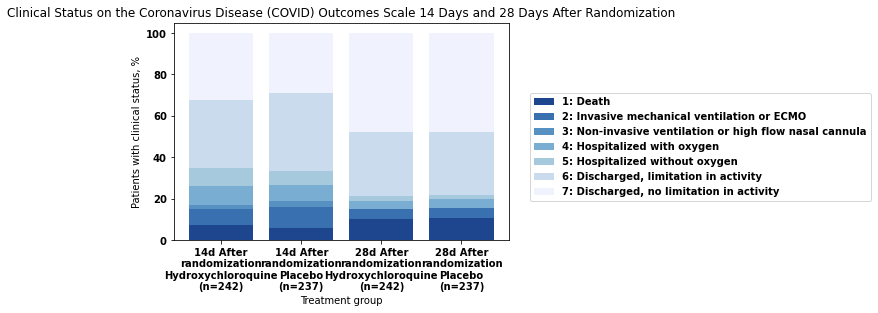

In [37]:
x = ['14d After\nrandomization\nHydroxychloroquine\n(n=242)', '14d After\nrandomization\nPlacebo\n(n=237)', 
     '28d After\nrandomization\nHydroxychloroquine\n(n=242)', '28d After\nrandomization\nPlacebo\n(n=237)']
title = "Clinical Status on the Coronavirus Disease (COVID) Outcomes Scale 14 Days and 28 Days After Randomization"
# Matplotlib display parameters
plt.rcParams["figure.figsize"] = (25,20)
font = {'weight' : 'bold',
        'size'   : 35}
plt.rc('font', **font)

plt.bar(x, y0, color='#1D468F')
plt.bar(x, y1, bottom=y0, color='#3971B0')
plt.bar(x, y2, bottom=y0+y1, color='#5791C1')
plt.bar(x, y3, bottom=y0+y1+y2, color='#7AADD2')
plt.bar(x, y4, bottom=y0+y1+y2+y3, color='#A7C9DE')
plt.bar(x, y5, bottom=y0+y1+y2+y3+y4, color='#CADBED')
plt.bar(x, y6, bottom=y0+y1+y2+y3+y4+y5, color='#F0F3FE')
plt.xlabel("Treatment group")
plt.ylabel("Patients with clinical status, %")
plt.legend(labels, bbox_to_anchor = (1.05, 0.7))
plt.title(title)
plt.show()